<a href="https://colab.research.google.com/github/plaban1981/TOPIC_Modeling_NLP/blob/main/class_based_TF_IDF_with_Scikit_Learn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

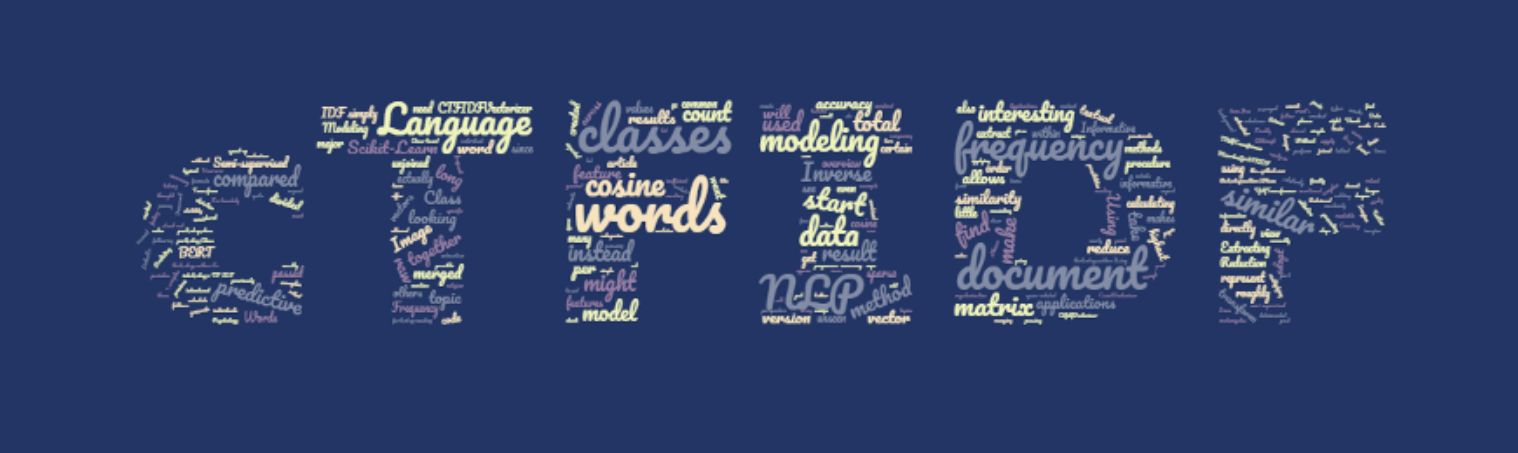

#### Class-based TF-IDF

Before going into the possibilities of this class-based TF-IDF, let us first look at how TF-IDF works and the steps we need to take to transform it into c-TF-IDF.

#### TF-IDF

TF-IDF is a method for generating features from textual documents which is the result of multiplying two methods:

* **Term Frequency (TF) :** The term frequency is simply the raw count of words within a document where each word count is considered a feature.


* **Inverse Document Frequency (IDF) :** Inverse document frequency extracts how informative certain words are by calculating a word’s frequency in a document compared to its frequency across all other documents.


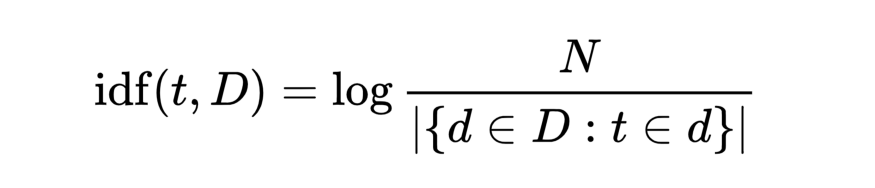

*  Inverse document frequency punishes words that are too common.

#### Transform TF-IDF into c-TF-IDF

* The goal of the class-based TF-IDF is to supply all documents within a single class with the same class vector. 

* In order to do so, we have to start looking at TF-IDF from a class-based point of view instead of individual documents.

* If documents are not individuals, but part of a larger collective, then it might be interesting to actually regard them as such by joining all documents in a class together.

* Then, instead of applying TF-IDF to the newly created long documents, we have to take into account that TF-IDF will take the number of classes instead of the number of documents since we merged documents.

In [1]:
import pandas as pd
import numpy as np
import scipy.sparse as sp

In [2]:
from sklearn.preprocessing import normalize
from sklearn.feature_extraction.text import TfidfTransformer,CountVectorizer

In [3]:
class CTFIDFVectorizer(TfidfTransformer):
    def __init__(self, *args, **kwargs):
        super(CTFIDFVectorizer, self).__init__(*args, **kwargs)

    def fit(self, X: sp.csr_matrix, n_samples: int):
        """Learn the idf vector (global term weights) """
        _, n_features = X.shape
        df = np.squeeze(np.asarray(X.sum(axis=0)))
        idf = np.log(n_samples / df)
        self._idf_diag = sp.diags(idf, offsets=0,
                                  shape=(n_features, n_features),
                                  format='csr',
                                  dtype=np.float64)
        return self

    def transform(self, X: sp.csr_matrix) -> sp.csr_matrix:
        """Transform a count-based matrix to c-TF-IDF """
        X = X * self._idf_diag
        X = normalize(X, axis=1, norm='l1', copy=False)
        return X

* We have adopted TfidfTransformer to fit and transform methods to make it into the CtfidfVectorizer. 

* The vectorizer takes in a sparse matrix that contains the raw count data.

In [4]:
# Get data
from sklearn.datasets import fetch_20newsgroups
newsgroups = fetch_20newsgroups(subset='train', remove=('headers', 'footers', 'quotes'))

In [5]:
newsgroups.keys()

dict_keys(['data', 'filenames', 'target_names', 'target', 'DESCR'])

In [6]:
docs = pd.DataFrame({'Document':newsgroups.data,'Class':newsgroups.target})
docs.head()

,Document,Class
0,I was wondering if anyone out there could enli...,7
1,A fair number of brave souls who upgraded thei...,4
2,"well folks, my mac plus finally gave up the gh...",4
3,\nDo you have Weitek's address/phone number? ...,1
4,"From article <C5owCB.n3p@world.std.com>, by to...",14


## Create Documents per Class

In [7]:
doc_per_class = docs.groupby(['Class'],as_index=False).agg({'Document': " ".join})
doc_per_class

,Class,Document
0,0,\nDon't be so sure. Look what happened to Jap...
1,1,\nDo you have Weitek's address/phone number? ...
2,2,I have win 3.0 and downloaded several icons an...
3,3,...
4,4,A fair number of brave souls who upgraded thei...
5,5,QUESTION:\n What is the EXACT entry (paramete...
6,6,Reduced Prices! \nI have a list of things fors...
7,7,I was wondering if anyone out there could enli...
8,8,I have a line on a Ducati 900GTS 1978 model wi...
9,9,Doug Roberts - Ken Hill for NL MVP!!\n\t ...


## Create Class Based tfidf

In [9]:
# Create c-TF-IDF
count = CountVectorizer().fit_transform(doc_per_class['Document'])
ctfidf = CTFIDFVectorizer().fit_transform(count, n_samples=len(docs))

In [10]:
count.shape

(20, 101631)

In [12]:
ctfidf.shape

(20, 101631)

In [14]:
ctfidf.toarray()

array([[0.00000000e+00, 1.97184277e-04, 0.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [2.01711947e-04, 1.16051343e-04, 0.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [4.61729130e-05, 9.59282837e-06, 0.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       ...,
       [2.80461265e-05, 7.24191630e-04, 1.32120774e-05, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [9.65847461e-05, 4.25406188e-04, 0.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [9.97191217e-06, 1.11874628e-04, 0.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00]])

* **NOTE:** 

The n_samples passed through the CTFIDFVectorizer is the total number of unjoined documents. 

This is necessary as the IDF values become too small if the number of joined documents is passed instead.

## Applications

#### Informative Words per Class
What makes c-TF-IDF unique compared to TF-IDF is that we can adopt it such that we can search for words that make up certain classes.

- to do this extract the c-TF-IDF matrix and find the highest values in each class:

In [16]:
#create bag of words
count_vectorizer = CountVectorizer().fit(doc_per_class['Document'])
count = count_vectorizer.transform(doc_per_class['Document'])
words = count_vectorizer.get_feature_names()

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In [17]:
words

['00',
 '000',
 '0000',
 '00000',
 '000000',
 '00000000',
 '0000000004',
 '00000000b',
 '00000001',
 '00000001b',
 '00000010',
 '00000010b',
 '00000011',
 '00000011b',
 '00000074',
 '00000093',
 '000000e5',
 '00000100',
 '00000100b',
 '00000101',
 '00000101b',
 '00000110',
 '00000110b',
 '00000111',
 '00000111b',
 '000005102000',
 '00000510200001',
 '00000ee5',
 '00001000',
 '00001000b',
 '00001001',
 '00001001b',
 '00001010',
 '00001010b',
 '00001011',
 '00001011b',
 '000010af',
 '00001100',
 '00001100b',
 '00001101',
 '00001101b',
 '00001110',
 '00001110b',
 '00001111',
 '00001111b',
 '000042',
 '000062david42',
 '000094',
 '0001',
 '00010000',
 '00010000b',
 '00010001',
 '00010001b',
 '00010010',
 '00010010b',
 '00010011',
 '00010011b',
 '000100255pixel',
 '00010100',
 '00010100b',
 '00010101',
 '00010101b',
 '00010110',
 '00010110b',
 '00010111',
 '00010111b',
 '00011000',
 '00011000b',
 '00011001',
 '00011001b',
 '00011010',
 '00011010b',
 '00011011',
 '00011011b',
 '00011100',
 '

In [19]:
# Extract top 10 words per class
ctfidf = CTFIDFVectorizer().fit_transform(count,n_samples=len(docs)).toarray()

In [20]:
words_per_class = {}
for label in doc_per_class['Class']:
  k = newsgroups.target_names[label]
  v = [words[index] for index in ctfidf[label].argsort()[-10:]]
  words_per_class[k] =v

In [21]:
words_per_class

{'alt.atheism': ['belief',
  'jesus',
  'religious',
  'atheist',
  'islam',
  'argument',
  'religion',
  'atheists',
  'god',
  'atheism'],
 'comp.graphics': ['software',
  'color',
  '3d',
  'files',
  'format',
  'gif',
  'images',
  'jpeg',
  'graphics',
  'image'],
 'comp.os.ms-windows.misc': ['0t',
  '1t',
  '34u',
  '1d9',
  '145',
  'pl',
  'a86',
  'b8f',
  'g9v',
  'max'],
 'comp.sys.ibm.pc.hardware': ['hard',
  'bios',
  'disk',
  'bus',
  'card',
  'drives',
  'ide',
  'controller',
  'drive',
  'scsi'],
 'comp.sys.mac.hardware': ['lc',
  'quadra',
  'ram',
  'monitor',
  'nubus',
  'simms',
  'scsi',
  'drive',
  'apple',
  'mac'],
 'comp.windows.x': ['application',
  'mit',
  'program',
  'output',
  'file',
  'server',
  'entry',
  'motif',
  'widget',
  'window'],
 'misc.forsale': ['10',
  'asking',
  'price',
  'condition',
  'dos',
  '50',
  'offer',
  'shipping',
  'sale',
  '00'],
 'rec.autos': ['speed',
  'autos',
  'driving',
  'tires',
  'ford',
  'dealer',
  'o

In [22]:
words_per_class['alt.atheism']

['belief',
 'jesus',
 'religious',
 'atheist',
 'islam',
 'argument',
 'religion',
 'atheists',
 'god',
 'atheism']

## Class Reduction

In [24]:
from sklearn.metrics.pairwise import cosine_similarity

# Get similar classes
distances = cosine_similarity(ctfidf, ctfidf)
np.fill_diagonal(distances, 0)

# For each class, extract the most similar class
result = pd.DataFrame([(newsgroups.target_names[index], 
                        newsgroups.target_names[distances[index].argmax()])
                       for index in range(len(doc_per_class))],
                      columns=["From", "To"])

In [25]:
result

,From,To
0,alt.atheism,soc.religion.christian
1,comp.graphics,comp.windows.x
2,comp.os.ms-windows.misc,comp.sys.ibm.pc.hardware
3,comp.sys.ibm.pc.hardware,comp.sys.mac.hardware
4,comp.sys.mac.hardware,comp.sys.ibm.pc.hardware
5,comp.windows.x,sci.electronics
6,misc.forsale,comp.sys.mac.hardware
7,rec.autos,rec.motorcycles
8,rec.motorcycles,rec.autos
9,rec.sport.baseball,talk.politics.misc


## Semi-supervised Modeling

Using c-TF-IDF we can even perform semi-supervised modeling directly without the need for a predictive model.


* We start by creating a c-TF-IDF matrix for the train data. 

* The result is a vector per class which should represent the content of that class. 

* Finally, we check, for previously unseen data, how similar that vector is to that of all categories:

In [26]:
from sklearn import metrics
from sklearn.datasets import fetch_20newsgroups
from sklearn.metrics.pairwise import cosine_similarity

# Get train data
train = fetch_20newsgroups(subset='train', remove=('headers', 'footers', 'quotes'))
docs = pd.DataFrame({'Document': train.data, 'Class': train.target})
docs_per_class = docs.groupby(['Class'], as_index=False).agg({'Document': ' '.join})

# Create c-TF-IDF based on the train data
count_vectorizer = CountVectorizer().fit(docs_per_class.Document)
count = count_vectorizer.transform(docs_per_class.Document)
ctfidf_vectorizer = CTFIDFVectorizer().fit(count, n_samples=len(docs))
ctfidf = ctfidf_vectorizer.transform(count)

# Predict test data
test = fetch_20newsgroups(subset='test', remove=('headers', 'footers', 'quotes'))
count = count_vectorizer.transform(test.data)
vector = ctfidf_vectorizer.transform(count)
distances = cosine_similarity(vector, ctfidf)
prediction = np.argmax(distances, 1)

print(metrics.classification_report(test.target, prediction, target_names=test.target_names))

                          precision    recall  f1-score   support

             alt.atheism       0.21      0.59      0.31       319
           comp.graphics       0.53      0.63      0.58       389
 comp.os.ms-windows.misc       0.00      0.00      0.00       394
comp.sys.ibm.pc.hardware       0.54      0.53      0.54       392
   comp.sys.mac.hardware       0.61      0.60      0.60       385
          comp.windows.x       0.77      0.60      0.67       395
            misc.forsale       0.60      0.66      0.63       390
               rec.autos       0.63      0.67      0.65       396
         rec.motorcycles       0.85      0.58      0.69       398
      rec.sport.baseball       0.76      0.63      0.69       397
        rec.sport.hockey       0.91      0.39      0.55       399
               sci.crypt       0.83      0.51      0.63       396
         sci.electronics       0.46      0.49      0.48       393
                 sci.med       0.56      0.59      0.58       396
         